In [1]:
#imports
import numpy as np
import pandas as pd
from pybrain.datasets import SequentialDataSet
from itertools import cycle
from pybrain.tools.shortcuts import buildNetwork
from pybrain.structure.modules import LSTMLayer
from pybrain.supervised import RPropMinusTrainer
import matplotlib.pyplot as plt
from random import randrange
%matplotlib inline

In [2]:
##Error function
def error_in_prediction(predicted_sample, actual_next_sample):
    if type(predicted_sample) is list:
        predicted_sample = np.array(predicted_sample)
    if type(actual_next_sample) is list:
        actual_next_sample = np.array(actual_next_sample)
    error = np.mean(np.square(predicted_sample - actual_next_sample))
    return error

In [8]:
def create_irregular_sin_ds(numPoints, numSelPoints):
    x = np.linspace(-10, 10, numPoints)
    data = np.sin(x)
    randomIndex = []
    while len(randomIndex) < numSelPoints:
        val = randrange(0,len(data))
        if val not in randomIndex:
            randomIndex.append(val)
    index = np.sort(randomIndex)
    data_irregular = list(data[index])
    time_irregular = list(x[index])
    dat = np.vstack([time_irregular, data_irregular])
    delta_t = [0] + list(np.array(time_irregular[1:]) - \
                     np.array(time_irregular[:-1]))
    derivative = np.divide(np.diff(data_irregular), np.diff(data_irregular))
    magDerivative = np.lib.pad(derivative, (1,0), 'edge')
    dDerivative = np.lib.pad(np.diff(magDerivative), (1,0), 'edge')
    #Creating the sequential dataset for training LSTM
    resp = np.lib.pad(data_irregular[1:], (0,1), 'edge')
    feature_list = [data_irregular, time_irregular, delta_t, magDerivative, dDerivative]
    feats = np.vstack(feature_list)
    ds = SequentialDataSet(5,1)
    for feat, res in zip(feats.T, resp):
        ds.addSample(list(feat), res)
    return ds, dat.T

In [9]:
def trainLSTM(net, cycles, dataset, epochs_per_cycle, lstmLayerWidth):
    trainer = RPropMinusTrainer(net, dataset = dataset)
    for i in xrange(cycles+1):
        trainer.trainEpochs(epochs_per_cycle)
    state_values = [[] for k in range(lstmLayerWidth)]
    state_val = list(net['hidden0'].state)[:len(dataset)]
    for state in state_val:
        for k in range(lstmLayerWidth):
            state_values[k].append(state[k])
    return state_values

#### Next time step predictive function

In [10]:
##Plotting function
def gen_state_iteration_plot(lstm_width, state_values, net, ds,\
        it_num, name, save=False, return_error=False):
    if save == True:
        #Required to clear the plots in case the function is used to save
        #the plots
        plt.cla()
    f, axarr = plt.subplots(2, 2, figsize=(10,10))
    for k in range(lstm_width):
        axarr[1,0].plot(state_values[k], label='State '+str(k+1))
        if lstm_width > 1:
            if k == 0:
                master_state = state_values[k]
            else:
                master_state = [sum(x) for x in zip(master_state,\
                    state_values[k])]
    if lstm_width > 1:
        axarr[1,0].plot(master_state, label='adding all states')
    axarr[1,0].legend(prop={'size':6})
    axarr[1,0].set_title('State values after '+str(it_num)+\
            ' training iterations')
    axarr[1,0].set_xlabel('Time steps')
    axarr[1,0].set_ylabel('Magnitude')

    current_input = []
    predicted_sample = []
    actual_next_sample = []
    time =[]
    for sample, target in ds.getSequenceIterator(0):
        current_input.append(sample[0])
        time.append(sample[1])
        predicted_sample.append(net.activate(sample))
        actual_next_sample.append(target)

    #Calculating the error    
    error = error_in_prediction(predicted_sample, actual_next_sample)
    
    #calculating number of points
    numPoints = len(current_input)
    #Plotting the input, predicted output and actual output
    axarr[0,0].plot(range(len(current_input)),current_input, label='Input')
    axarr[0,1].plot(range(len(predicted_sample)),predicted_sample,\
            label='Predicted sample')
    axarr[1,1].plot(range(len(actual_next_sample)),actual_next_sample, \
        label = 'Actual next sample')
    axarr[0,0].set_xlabel('Time steps')
    axarr[0,0].set_ylabel('Magnitude')
    axarr[0,0].set_title('Input')
    axarr[0,1].set_xlabel('Time steps')
    axarr[0,1].set_ylabel('Magnitude')
    axarr[0,1].set_title('Predicted Sample')
    axarr[1,1].set_xlabel('Time steps')
    axarr[1,1].set_ylabel('Magnitude')
    axarr[1,1].set_title('Actual next Sample')
    if save == True:
        plt.savefig('../graphs/Irregular_time_intervals/'+str(len(ds))\
                    +'/'+str(lstm_width)+'/'\
            +name+'_training_iterations_'+str(it_num)+'.png')
        plt.close()
        plt.clf()
    else:
        plt.show()
        
    if return_error == True:
        return error
    else:
        print "Error in prediction :"+str(error)

In [61]:
ds, data = create_irregular_sin_ds(200, 60)

In [62]:
#Specifying parameters for the LSTM
lstmLayerWidth = 10
outdim = 1
indim = 5
cycles_per_file = 500
epochs_per_cycle = 1
net = buildNetwork(indim,lstmLayerWidth,outdim, hiddenclass=LSTMLayer, \
                       outputbias=False, recurrent=True)  

In [63]:
state_values = trainLSTM(net, cycles_per_file, ds, epochs_per_cycle, lstmLayerWidth)

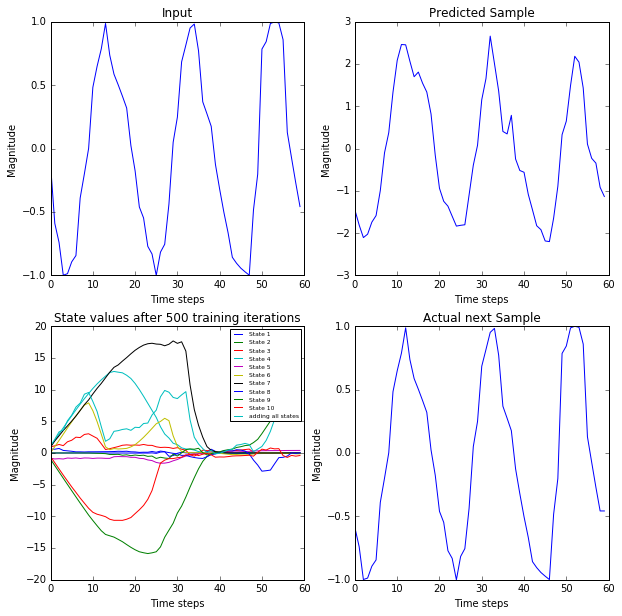

Error in prediction :0.722094981957


In [64]:
gen_state_iteration_plot(lstmLayerWidth,\
                state_values, net, ds, cycles_per_file, 'sin')

#### One time step predictive function

In [19]:
#Function creates the features which are then used to predict the next magnitude
def gen_training_data(mag_n1, mag_n2, predicted_mag, time_prev, time_next):
    """
    INPUT
    mag_n1 - magnitude at time n-1
    mag_n2 - magnitude at time n-2
    predicted_mag - predicted magnitude at time n
    time_prev - time value at the previous step at which prediction was made
    time_next - time value at the next step the prediction is to be made
    """
    #To check if the next time value is greater than the previous time value for which the prediction was made
    assert time_next > time_prev
    out  = [predicted_mag, time_next, time_next-time_prev, predicted_mag-mag_n1, predicted_mag-mag_n2]
    return out

In [50]:
##Plotting function
def gen_testing_data_plot(lstm_width, state_values, net,\
        data, name, it_num, save=False, return_error=False):
    if save == True:
        #Required to clear the plots in case the function is used to save
        #the plots
        plt.cla()
    f, axarr = plt.subplots(2, 2, figsize=(10,10))
    for k in range(lstm_width):
        axarr[1,0].plot(state_values[k], label='State '+str(k+1))
        if lstm_width > 1:
            if k == 0:
                master_state = state_values[k]
            else:
                master_state = [sum(x) for x in zip(master_state,\
                    state_values[k])]
    if lstm_width > 1:
        axarr[1,0].plot(master_state, label='adding all states')
    axarr[1,0].legend(prop={'size':6})
    axarr[1,0].set_title('State values after '+str(it_num)+\
            ' training iterations')
    axarr[1,0].set_xlabel('Time steps')
    axarr[1,0].set_ylabel('Magnitude')

    data_arr = np.array(data)
    time = data_arr[:,0] - data_arr[0,0]
    mag = data_arr[:,1]
    resp = np.lib.pad(mag[1:], (0,1), 'edge')
    #need this to calculate derivatives
    #variables holding key values required for estimation
    mag_pred = [mag[0], mag[0], mag[0]]
    pred_check = [mag[0], mag[0]]
    current_input = []
    predicted_sample = []
    actual_next_sample = []
    time_vec = []
    #Since we know the first time and magnitude pair to start the prediction
    for t_idx in range(1,len(time)):
        next_sample = gen_training_data(mag_pred[t_idx-1], mag_pred[t_idx], pred_check[-1], \
                                   time[t_idx-1], time[t_idx])
        current_input.append(mag_pred[t_idx+1])
        time_vec.append(time[t_idx])
        pred = net.activate(next_sample)
        mag_pred.append(mag[t_idx])
        pred_check.append(pred)
        predicted_sample.append(pred)
        actual_next_sample.append(resp[t_idx-1])

    #Calculating the error    
    error = error_in_prediction(predicted_sample, actual_next_sample)
    #calculating number of points
    numPoints = len(current_input)
    #Plotting the input, predicted output and actual output
    axarr[0,0].plot(time_vec,current_input, label='Input')
    axarr[0,1].plot(time_vec,predicted_sample,\
            label='Predicted sample')
    axarr[1,1].plot(time_vec,actual_next_sample, \
        label = 'Actual next sample')
    axarr[0,0].set_xlabel('Time')
    axarr[0,0].set_ylabel('Magnitude')
    axarr[0,0].set_title('Input')
    axarr[0,1].set_xlabel('Time')
    axarr[0,1].set_ylabel('Magnitude')
    axarr[0,1].set_title('Predicted Sample')
    axarr[1,1].set_xlabel('Time')
    axarr[1,1].set_ylabel('Magnitude')
    axarr[1,1].set_title('Actual next Sample')
    if save == True:
        plt.savefig('lpv_test.png')
        plt.close()
        plt.clf()
    else:
        plt.show()
        
    if return_error == True:
        return error
    else:
        print "Error in prediction :"+str(error)

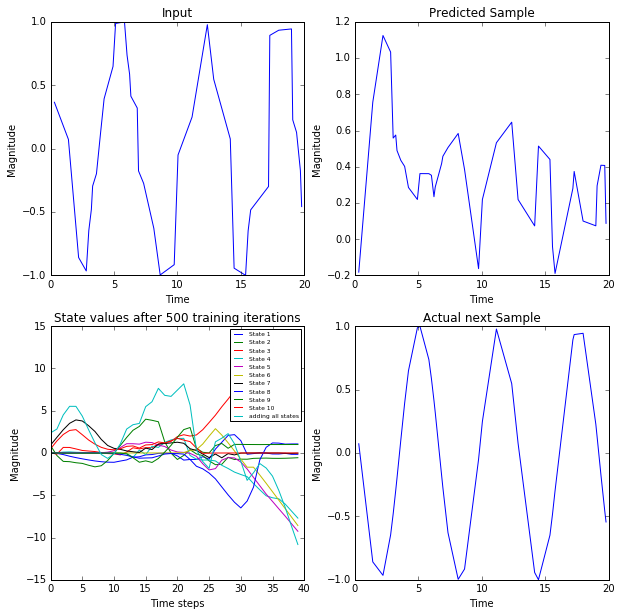

Error in prediction :0.618311770277


In [51]:
gen_testing_data_plot(lstmLayerWidth, state_values, net,\
        data, 'irr_sin', cycles_per_file)

#### Two time step predictive function

In [58]:
##Plotting function
def gen_testing_data_plot2(lstm_width, state_values, net,\
        data, name, it_num, save=False, return_error=False):
    if save == True:
        #Required to clear the plots in case the function is used to save
        #the plots
        plt.cla()
    f, axarr = plt.subplots(2, 2, figsize=(10,10))
    for k in range(lstm_width):
        axarr[1,0].plot(state_values[k], label='State '+str(k+1))
        if lstm_width > 1:
            if k == 0:
                master_state = state_values[k]
            else:
                master_state = [sum(x) for x in zip(master_state,\
                    state_values[k])]
    if lstm_width > 1:
        axarr[1,0].plot(master_state, label='adding all states')
    axarr[1,0].legend(prop={'size':6})
    axarr[1,0].set_title('State values after '+str(it_num)+\
            ' training iterations')
    axarr[1,0].set_xlabel('Time steps')
    axarr[1,0].set_ylabel('Magnitude')

    data_arr = np.array(data)
    time = data_arr[:,0] - data_arr[0,0]
    mag = data_arr[:,1]
    resp = np.lib.pad(mag[1:], (0,1), 'edge')
    #need this to calculate derivatives
    #variables holding key values required for estimation
    mag_pred = [mag[0], mag[0], mag[0]]
    pred_check = [mag[0], mag[0]]
    current_input = []
    predicted_sample = []
    actual_next_sample = []
    time_vec = []
    #Since we know the first time and magnitude pair to start the prediction
    for t_idx in range(1,len(time)):
        next_sample = gen_training_data(mag_pred[t_idx-1], pred_check[-2], pred_check[-1], \
                                   time[t_idx-1], time[t_idx])
        current_input.append(mag_pred[t_idx+1])
        time_vec.append(time[t_idx])
        pred = net.activate(next_sample)
        mag_pred.append(mag[t_idx])
        pred_check.append(pred)
        predicted_sample.append(pred)
        actual_next_sample.append(resp[t_idx-1])

    #Calculating the error    
    error = error_in_prediction(predicted_sample, actual_next_sample)
    #calculating number of points
    numPoints = len(current_input)
    #Plotting the input, predicted output and actual output
    axarr[0,0].plot(time_vec,current_input, label='Input')
    axarr[0,1].plot(time_vec,predicted_sample,\
            label='Predicted sample')
    axarr[1,1].plot(time_vec,actual_next_sample, \
        label = 'Actual next sample')
    axarr[0,0].set_xlabel('Time')
    axarr[0,0].set_ylabel('Magnitude')
    axarr[0,0].set_title('Input')
    axarr[0,1].set_xlabel('Time')
    axarr[0,1].set_ylabel('Magnitude')
    axarr[0,1].set_title('Predicted Sample')
    axarr[1,1].set_xlabel('Time')
    axarr[1,1].set_ylabel('Magnitude')
    axarr[1,1].set_title('Actual next Sample')
    if save == True:
        plt.savefig('lpv_test.png')
        plt.close()
        plt.clf()
    else:
        plt.show()
        
    if return_error == True:
        return error
    else:
        print "Error in prediction :"+str(error)

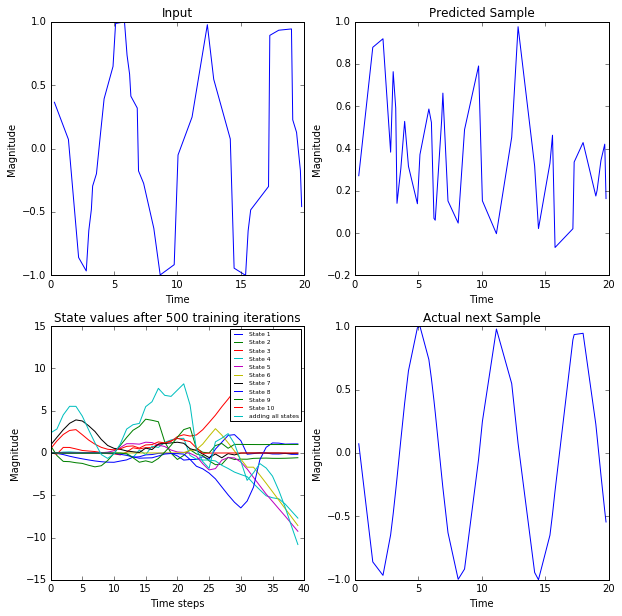

Error in prediction :0.619585345267


In [59]:
gen_testing_data_plot2(lstmLayerWidth, state_values, net,\
        data, 'irr_sin', cycles_per_file)

#### Three time step predictive function

In [57]:
##Plotting function
def gen_testing_data_plot3(lstm_width, state_values, net,\
        data, name, it_num, save=False, return_error=False):
    if save == True:
        #Required to clear the plots in case the function is used to save
        #the plots
        plt.cla()
    f, axarr = plt.subplots(2, 2, figsize=(10,10))
    for k in range(lstm_width):
        axarr[1,0].plot(state_values[k], label='State '+str(k+1))
        if lstm_width > 1:
            if k == 0:
                master_state = state_values[k]
            else:
                master_state = [sum(x) for x in zip(master_state,\
                    state_values[k])]
    if lstm_width > 1:
        axarr[1,0].plot(master_state, label='adding all states')
    axarr[1,0].legend(prop={'size':6})
    axarr[1,0].set_title('State values after '+str(it_num)+\
            ' training iterations')
    axarr[1,0].set_xlabel('Time steps')
    axarr[1,0].set_ylabel('Magnitude')

    data_arr = np.array(data)
    time = data_arr[:,0] - data_arr[0,0]
    mag = data_arr[:,1]
    resp = np.lib.pad(mag[1:], (0,1), 'edge')
    #need this to calculate derivatives
    #variables holding key values required for estimation
    mag_pred = [mag[0], mag[0], mag[0]]
    pred_check = [mag[0], mag[0], mag[0]]
    current_input = []
    predicted_sample = []
    actual_next_sample = []
    time_vec = []
    #Since we know the first time and magnitude pair to start the prediction
    for t_idx in range(1,len(time)):
        next_sample = gen_training_data(pred_check[-3], pred_check[-2], pred_check[-1], \
                                   time[t_idx-1], time[t_idx])
        current_input.append(mag_pred[t_idx+1])
        time_vec.append(time[t_idx])
        pred = net.activate(next_sample)
        mag_pred.append(mag[t_idx])
        pred_check.append(pred)
        predicted_sample.append(pred)
        actual_next_sample.append(resp[t_idx-1])

    #Calculating the error    
    error = error_in_prediction(predicted_sample, actual_next_sample)
    #calculating number of points
    numPoints = len(current_input)
    #Plotting the input, predicted output and actual output
    axarr[0,0].plot(time_vec,current_input, label='Input')
    axarr[0,1].plot(time_vec,predicted_sample,\
            label='Predicted sample')
    axarr[1,1].plot(time_vec,actual_next_sample, \
        label = 'Actual next sample')
    axarr[0,0].set_xlabel('Time')
    axarr[0,0].set_ylabel('Magnitude')
    axarr[0,0].set_title('Input')
    axarr[0,1].set_xlabel('Time')
    axarr[0,1].set_ylabel('Magnitude')
    axarr[0,1].set_title('Predicted Sample')
    axarr[1,1].set_xlabel('Time')
    axarr[1,1].set_ylabel('Magnitude')
    axarr[1,1].set_title('Actual next Sample')
    if save == True:
        plt.savefig('lpv_test.png')
        plt.close()
        plt.clf()
    else:
        plt.show()
        
    if return_error == True:
        return error
    else:
        print "Error in prediction :"+str(error)

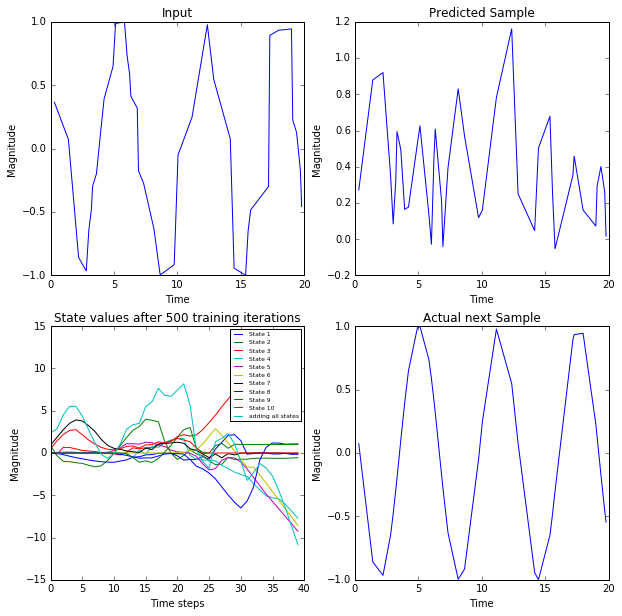

Error in prediction :0.635366497285


In [60]:
gen_testing_data_plot3(lstmLayerWidth, state_values, net,\
        data, 'irr_sin', cycles_per_file)